In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [2]:
# Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [3]:
# Diretório onde estão armazenadas as imagens sem ser separadas por pastas
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Caminho para o arquivo de IDs das imagens com fundo dark
ids_dark = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\dark_images_ids.txt'

In [7]:
# Carregar IDs do grupo de treinamento de um arquivo de texto
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]
    
print(f"Número de IDs carregados: {len(ids)}")
print(f"Primeiros 5 IDs: {ids[:5]}")

Número de IDs carregados: 9649
Primeiros 5 IDs: ['10000', '10001', '10002', '10003', '10004']


In [8]:
# Dividir os IDs em treinamento e validação (por exemplo, 80% para treinamento e 20% para validação)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [10]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue

        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue

        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue

        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [11]:
print(f"Número de imagens no conjunto de treinamento: {len(train_data)}")
print(f"Número de imagens no conjunto de validação: {len(val_data)}")

Número de imagens no conjunto de treinamento: 7718
Número de imagens no conjunto de validação: 1930


In [12]:
# Separar caminhos de imagem e rótulos para treinamento e validação
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

In [13]:
# Converter os rótulos em formato adequado (numérico), se necessário
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [14]:
# Transformar os rótulos em one-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [15]:
# Criar gerador de dados personalizado
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(112, 112)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i], self.target_size) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [16]:
# Criar os geradores de treinamento e validação
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=32)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=32)

In [17]:
# Carregar o modelo base VGG16 com pesos pré-treinados da ImageNet
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

58889256/58889256 [==============================] - 6s 0us/step


In [18]:
# Congelar as camadas da VGG16 para treinar apenas as camadas personalizadas
base_model_vgg16.trainable = False

In [19]:
# Adicionar novas camadas no topo do modelo base
x = base_model_vgg16.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [20]:
# Criar o modelo final
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

In [21]:
# Fine-tuning 
# Descongelar as últimas camadas da VGG16 para fazer fine-tuning
for layer in base_model_vgg16.layers[-4:]:
    layer.trainable = True

In [22]:
# Recompilar o modelo 
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [23]:
# Treinar o modelo com fine-tuning
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
242/242 [==============================] - 2006s 8s/step - loss: 1.3666 - accuracy: 0.4368 - val_loss: 1.1575 - val_accuracy: 0.5461
Epoch 2/10
242/242 [==============================] - 1947s 8s/step - loss: 1.0709 - accuracy: 0.5889 - val_loss: 0.9381 - val_accuracy: 0.6534
Epoch 3/10
242/242 [==============================] - 1949s 8s/step - loss: 0.9456 - accuracy: 0.6424 - val_loss: 0.8537 - val_accuracy: 0.6534
Epoch 4/10
242/242 [==============================] - 1957s 8s/step - loss: 0.8675 - accuracy: 0.6771 - val_loss: 0.7085 - val_accuracy: 0.7782
Epoch 5/10
242/242 [==============================] - 2083s 9s/step - loss: 0.8008 - accuracy: 0.7029 - val_loss: 0.6363 - val_accuracy: 0.7762
Epoch 6/10
242/242 [==============================] - 1955s 8s/step - loss: 0.7607 - accuracy: 0.7186 - val_loss: 0.5924 - val_accuracy: 0.7902
Epoch 7/10
242/242 [==============================] - 1954s 8s/step - loss: 0.7188 - accuracy: 0.7323 - val_loss: 0.5571 - val_accuracy:

In [24]:
# Salvar o modelo treinado
model_vgg16.save('trained_model.vgg16_dark')

INFO:tensorflow:Assets written to: trained_model.vgg16_dark\assets


INFO:tensorflow:Assets written to: trained_model.vgg16_dark\assets


In [25]:
# Avaliar o modelo usando o gerador de dados de validação
val_loss_vgg16, val_accuracy_vgg16 = model_vgg16.evaluate(val_generator)
print(f"Loss on validation set: {val_loss_vgg16}")
print(f"Accuracy on validation set: {val_accuracy_vgg16}")

61/61 [==============================] - 364s 6s/step - loss: 0.5065 - accuracy: 0.8130
Loss on validation set: 0.506476104259491
Accuracy on validation set: 0.8129533529281616


In [26]:
# Analisar os resultados com matriz de confusão e relatório de classificação
from sklearn.metrics import confusion_matrix, classification_report

# Carregar e processar as imagens de validação
val_images_processed = np.array([load_image(img_path) for img_path in val_images])

# Verificar se há alguma imagem que não foi carregada corretamente
val_images_processed = np.array([img for img in val_images_processed if img is not None])

# Obter previsões do modelo
val_predictions = model_vgg16.predict(val_images_processed)

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
target_names = label_encoder.classes_  # Usar as classes reais
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

61/61 [==============================] - 54s 875ms/step
Matriz de Confusão:
[[327  62  22  51   6]
 [  2 284   2  19  12]
 [  3   3 333  15   6]
 [  4  13  28 319   1]
 [  2  60  14  36 306]]
Relatório de Classificação:
              precision    recall  f1-score   support

  B.subtilis       0.97      0.70      0.81       468
  C.albicans       0.67      0.89      0.77       319
      E.coli       0.83      0.93      0.88       360
P.aeruginosa       0.72      0.87      0.79       365
    S.aureus       0.92      0.73      0.82       418

    accuracy                           0.81      1930
   macro avg       0.82      0.82      0.81      1930
weighted avg       0.84      0.81      0.81      1930



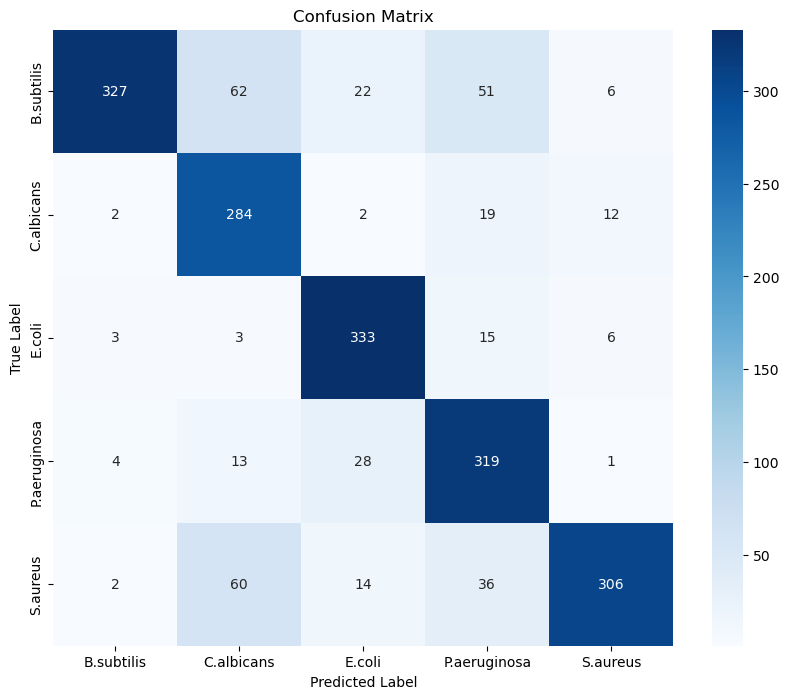

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

__Acurácia:__ O modelo alcançou uma acurácia de validação de aproximadamente 81.3%, o que indica que ele está performando razoavelmente bem,

__Matriz de Confusão:__ A matriz de confusão mostra que o modelo tem dificuldades em distinguir algumas classes, como B.subtilis e C.albicans, e S.aureus e C.albicans. Isso sugere que as características dessas classes podem ser semelhantes para o modelo, resultando em confusões